Peter Mann (2018) [University of St Andrews].

# The Ising model

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) is a spin-lattice model that describes ferromagnetism. It consists of a $d$-dimensional finite lattice of connected sites, $\Lambda_d$, that each posess a discrete variable $\sigma_k\in \{-1,+1\}$, representing the site's **spin**. A **spin configuration** for the model is an assignment of a spin to each site in the lattice; for $N$ lattice sites, there are $2^N$ configurations. Two adjacent sites interact with one another through an interaction $J_{ij}$. In two dimensions, in the absence of any external fields, the Hamiltonian is

$$
H = -J\sum_{<ij>}S_iS_j
$$

where $<ij>$ indicates that $i$ and $j$ are neighbours and $J_{ij}=J$ $\forall i,j \in \Lambda_d$. The system undergoes a 2nd order phase transition at the critical temperature $T_c$. Below this, the spins are ordered, meaning global order arises from local spin-spin energy minimising interaction. Above $T_c$ the spins are disordered, there are no long-range correlations between them and the system maximizes entropy.

The boundary conditions of the lattice have an affect on the spin dynamics; they can periodic, fixed or free. Periodic boundary conditions endow translational invariance to the system and create a toroidal topology such that $(1,y)$ and $(N,y)$ are connected. Fixed and free conditions generate strong boundary effects since they have fewer neighbours or are held at fixed 'surface energies'.

The Ising model is perhaps the simplest spin lattice process that describes magnetism in solids. Generalisations include:

* **Spins**: XY model, Heisenberg, Potts, Kawasaki (exchange dynamics) ... 
* **Lattice**: square, triangle, cubic, honeycombe ... 
* **Interactions**: Next nearest neighbour, external fields, anti-ferromagnetism ... 

## A simulation 

We will simulate a 2-dimensional Ising lattice and generate configurations using the **Metropolis-Hastings** (MCMC) algorithm. The main steps are to initialise the lattice with a spin configuration. A site is chosen at random its spin is temporarily flipped and the change in energy to the local environment this causes, is computed. If the change is negative ($dH<0$) or if a random number $r$ is less than $r<e^{-dH/T}$, then the flip is accepted and a new configuration is generated, otherwise it returns to its original state. We then repeat this process until equilibrium is reached. 

This algorithm is quite rudimentary; small system sizes run quicker, but suffer finite-size effects, while larger systems require more Monte Carlo updates to reach thermal equilibrium and have longer correlation times (the number of MCMC updates required to reach a configuration that is statistically uncorrelated to the current one). There are a number of improvements to the basic approach such as the **Swendsen–Wang** algorithm or the **Wolff** algorithm, which  flip clusters of spins or grids rather than individuals meaning they are therefore non-local. 

We will subclass the `LatticeProcess` class to base our Ising simulation over a `networkx` framework. We first compute the equilibrium lattice energy and magnetisation before viewing snapshots of the process. The use of `networkx` to generate our lattice has the advantage of quickly changing the lattice topology with no effect on the code structure under the hood. This also fixes how we will traverse the sites (in ascending order, at random ... ) and how we find the neighbours. 

In [1]:
from random import choice
import numpy as np
import networkx
import epyc
from numpy.random import rand

# for figures in notebook
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

In [2]:
class LatticeProcess( epyc.Experiment ):
    '''Base class that generates a spin-lattice with an abstract 
    process running on it. The update dynamics and the process
    details can be subclassed.
    '''
    N = 'N'                       # size of lattice
    SPIN = 'spin'                 # key for nodes spin
    _BETA = 'beta'                # inverse temperature
    _NUM_UPDATES = 'num_updates'  # number of updates for dynamics

    def __init__(self):
        super(LatticeProcess, self).__init__()
        
    def configure( self, params ):
        '''Creates a 2-dimensional lattice. Each lattice point 
        is then given a spin (-1,+1) at random and the prototype 
        network is saved for later use. The lattice dimensions and 
        set of admissible spins can easily be modified.
        
        :param params: the experimental parameters'''
        epyc.Experiment.configure(self, params)
        N = params[self.N]
        
        # create an (NxN) 2-dimensional lattice with periodic boundary condition
        g = networkx.grid_graph(dim=[N,N],periodic=True)
        
        # initialise the nodes with a spin configuration
        for n in g.nodes():
            g.node[n][self.SPIN] = choice([-1, 1])
            
        # store it for later
        self._prototype = g
        
    def setUp( self, params ):
        '''Set up a working network for this run of the experiment.
        This is useful when performing lab experiments.
        :param params: the experimental parameters'''
        epyc.Experiment.setUp(self, params)
        self._network = self._prototype.copy()

    def tearDown( self ):
        '''Delete the current network.'''
        epyc.Experiment.tearDown(self)
        self._network = None

    def _magnetisation( self, g ):
        '''Computes the magnetisation of the state.
        :param g: the current lattice state
        :returns m: the magnetisation'''
        m = 0
        for n in g.nodes():
            m += g.node[n][self.SPIN]
        return m
    
    def _lattice_energy( self, g ):
        '''Computes the energy of a given state by 
        computing the local environment of every spin
        state in the lattice. The return is divided by
        the number of neighbours each site has (assuming
        it is a regular lattice) accounting for zero index. 
        
        :param g: the current lattice state
        :returns H: the current lattice energy'''
        energy = 0
        for n in g.nodes():
            ns = 0
            for nn in g.neighbors(n):
                ns += g.node[nn][self.SPIN]
            energy += - ns * g.node[n][self.SPIN]
        return energy/(len(g.neighbors(n))+1.0)
    
    def returnField( self, g, N ):
        '''Returns the spin field as a numpy array for post-processing
        or animation creation.'''
        # get spin attributes from network: returns dict as {node_id: spin}
        config = networkx.get_node_attributes(g,self.SPIN)
        
        # convert spins to array and reshape as lattice
        config_array = np.asarray(config.values()).reshape((N,N))
        return config_array
    
    def do( self, params ):
        '''Performs the simulation and returns the results.'''
        # initialise the parameters 
        N = params[self.N]                       # lattice dimension
        beta = params[self._BETA]                # inverse temperature
        num_updates = params[self._NUM_UPDATES]  # number of updates
        
        # create a results dict 
        rc = dict()
        
        # grab a copy of the network
        g = self._network
            
        # initialise system quantities
        lattice_energy = 0 
        magnetisation  = 0
        
        # update the dynamics 
        for i in range(num_updates):
            self.dynamics(g, beta)
            
            # compute expectation quantities 
            lattice_energy = self._lattice_energy(g)
            magnetisation = self._magnetisation(g)
            
        # store the equilibrium lattice
        eqm_state = self.returnField(g,N)
        
        # report equilibrium lattice energy, magnetisation and temperature
        rc['E'] = lattice_energy
        rc['M'] = magnetisation
        rc['T'] = 1.0/beta
        rc['C'] = eqm_state
        
        return rc

In [3]:
class IsingModel( LatticeProcess ):
    '''Subclasses the `LatticeProcess` to fill in the dynamics of 
    each update according to the Ising model under local Monte Carlo 
    updates. '''
    
    def __init__(self):
        super(IsingModel, self).__init__()
        
    def dynamics( self, g, beta ):
        '''Given a current lattice spin configuration, this 
        function executes a Monte Carlo update for the system.
        It first picks a site at random from the lattice, before 
        summing the spin states of its neighbours. The energy 
        is computed and the Metropolis-Hastings criteria is 
        evaluated to decide if the spin flip is kept or not. Since
        spins are +-1, multiplication by -1 will always flip the spin.
        The current spin configuration is then returned. 
        
        :param g: lattice
        :param beta: inverse temperature
        '''
        # pick a site at random
        n = choice(g.nodes())
        
        # grab a list of its neighbours
        nb = g.neighbors(n)
        
        # interate over the nearest neighbours and sum spins
        ns = 0
        for nn in nb:
            ns += g.node[nn][self.SPIN]
        
        # compute the energy change
        dH = 2 * g.node[n][self.SPIN] * ns
        
        # evaluate Metropolis condition
        if dH < 0 or rand() < np.exp(-dH*beta):
            g.node[n][self.SPIN] *= -1

        return g
    

In [4]:
# create a Lab instance for simulation
lab = epyc.Lab()

# set parameters for the model
lab[IsingModel.N] = 18
lab[IsingModel._BETA] = 1.0 /np.linspace(1, 4.5, 80)
lab[IsingModel._NUM_UPDATES] = 150000

# instance class
e = IsingModel()

# repetitions at each point in the parameter space
repetitions = 1

# run the experiment
lab.runExperiment(epyc.RepeatedExperiment(e, repetitions))

# create a dataframe 
df = lab.notebook().dataframe()

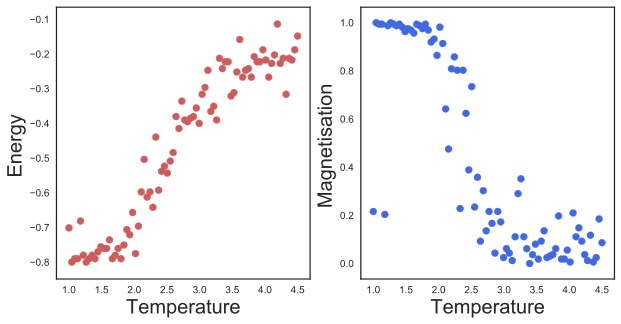

In [7]:
seaborn.set_style("white")

f = plt.figure(figsize=(10, 5))  

sp =  f.add_subplot(121)
plt.ylabel("Energy ", fontsize=20)
plt.xlabel("Temperature", fontsize=20)
plt.scatter(df['T'], (df['E']+0.0)/(df['N']*df['N']), s=50, marker='o', color='IndianRed')

sp =  f.add_subplot(122)
plt.ylabel("Magnetisation ", fontsize=20)
plt.xlabel("Temperature", fontsize=20)
plt.scatter(df['T'], abs(df['M']+0.0)/(df['N']*df['N']), s=50, marker='o', color='RoyalBlue')

In [ ]:
# To Do ... 

# specific heat + susceptibility + describe thermodynamics briefly,
# trace plots to see if each experiment equilibrates,
# animation of a single experiment,
# snap shots as a function of temperature.